### 9-13. 프로젝트: 뉴스기사 요약해보기

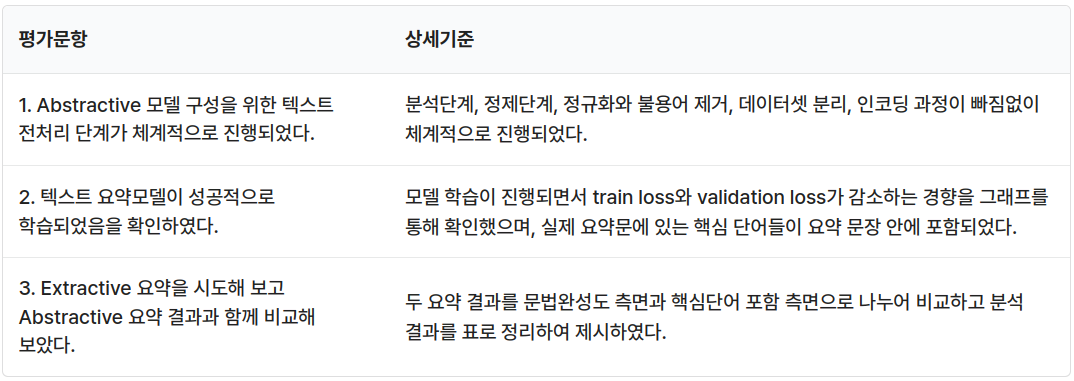


- 새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보자.



- 주요 라이브러리 버전을 확인

In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')


import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.2.0


### Step 1. 데이터 수집하기


- 데이터는 아래 링크에 있는 뉴스기사 데이터(news_summary_more.csv)를 사용.



- https://github.com/sunnysai12345/News_Summary  sunnysai12345/News_Summary




- 아래의 코드로 데이터를 다운

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
88477,Watch how meeting the in-laws can go wrong in ...,BigRock has released a new video featuring act...
12720,"My mom has become Yash, Roohi's official nanny...",Karan Johar has said that his mother Hiroo Joh...
37150,OPEC agrees oil output rise of 1 mn barrels: S...,Organisation of the Petroleum Exporting Countr...
28962,ICC panel decides not to scrap coin tossÃÂ fr...,ICC's Cricket Committee has decided not to scr...
9691,I love you most Ranno: Casting Director shares...,Yash Raj Films' Casting Director Shanoo Sharma...
55451,Dwayne Bravo becomes first bowler to take 400 ...,Windies' all-rounder Dwayne Bravo has become t...
42808,Man wins Ã¢ÂÂ¹6.5 cr as petrol pump staff ret...,A man in United States' Kansas said that he wo...
28609,Tennis player simulates masturbation with bott...,Australian tennis player Nick Kyrgios has been...
22385,15 yrs ago jaadu happened in my life: Hrithik ...,Hrithik Roshan has shared a post on his film '...
87608,Kedar Jadhav misses Champions Trophy flight af...,Cricketer Kedar Jadhav failed to travel to Eng...


In [4]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


- 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성.




- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습. 
  추출적 요약을 하는 경우에는 오직 text열만을 사용. 
  
  

### Step 2. 데이터 전처리하기 (추상적 요약)


- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보자. 
  만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보자.
  
  

####  전처리 -1) 중복 샘플 제거 - 중복 아닌 샘플수 확인 

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique()) # 또 t를 대문자로 치는 바람에
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


####  전처리 -2)  Null값 제거

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data))) 

전체 샘플수 : 98401


####  전처리 - 3)  텍스트 정규화 (text normalization) 

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 전처리 - 4) 불용어 제거



- NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거.


♣ NLTK ( Natural Language Toolkit)의 불용어(stopwords)




- 불용어(stopwords) : 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어.  

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

  


####  전처리 - 5)  소문자화등 기타 처리



 - 제거 :  1. html 태그, 2. 쌍따옴표 ", 3. 소유격 4. 불용어 5. 불용어 미제거
 
 - 변환 : 영어 외 문자(숫자, 특수문자 등) 공백으로 변환,  영어 외 문자(숫자, 특수문자 등) 공백으로 변환,  


- 함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋을 것 같다. 




- 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가


In [10]:
# 데이터 전처리 함수 
def preprocess_sentence(sentence, remove_stopwords=True): # remove_stopwords는 관용적 인자
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환 . Ex) ummmmmmm yeah -> umm yeah
    
    # text의 불용어 제거, 위코드서 word는 불용어, split은 공백기준으로 짜르고 for+ if로 돌려 join으로 한문장 만듬.
    if remove_stopwords: # if len(word) > 1) -> 단어의 길이가 1자 이상일때
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # headlines는 불용어 미제거되는건 1줄에서 remove_stopwords=True) 아래 False로 준건 else 에 적용.
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('쓩')

쓩


- text와 headlines의 임의 추출글이 전처리후 이렇게 바뀜.

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거X. 

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


- 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거. 또한 특수문자가 제거되면서 영어만 남았어요.


#### 전처리 - 6)  훈련 데이터 전체에 대해서 전처리 - Text 불용어를 제거 



- 이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행 : Text 불용어를 제거, headlines는 불용어를 제거안해서 따로 호출해서 진행.  결과 확인용 상위 5개의 줄을 출력
 

In [12]:
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸림. 
clean_text = []
for s in data['text']: # 노드는 대문자 Text 에러 안났는데 여기서  KeyError: 'Text'
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

#### 전처리 - 7)  훈련 데이터 전체에 대해서 전처리 - headlines 불용어를 제거

-  headlines에 대해서 전처리 함수를 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False.

In [13]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 1분 걸림.
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


#### 전처리 - 8)  빈(empty) 샘플이 생겼는지 확인

- 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 됨.

  보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('쓩')

쓩


- .isnull().sum()을 사용해서 Null 값이 생겼는지 확인

In [15]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [16]:
data.isnull().sum() #Q Text를 제거하려면 ?

headlines    0
text         0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


### 데이터 전처리하기 - 훈련데이터와 테스트데이터 나누기




- 학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시.

- 샘플의 최대 길이 정하기
  필요 없는 단어를 모두 솎아낸 데이터니, text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화
  

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299651426306644


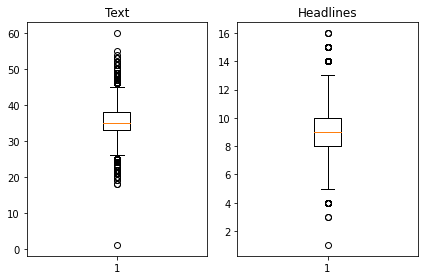

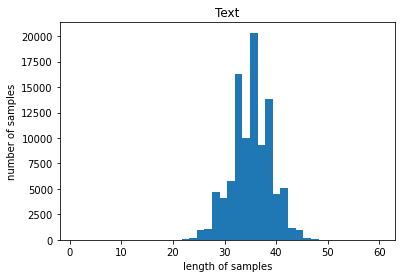

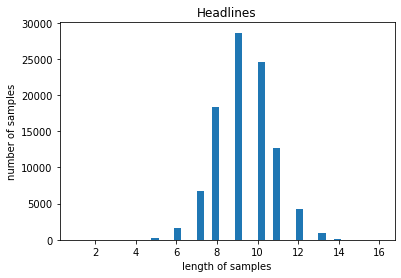

In [18]:
 # 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- Text는 박스플롯을 보면 40내외에 몰려있고 Headlines은 8 ~ 10에 몰려있음.  




- 이자료보고 Text의 최대 길이를 40,  Headlines의 적절한 최대 길이를 10 으로설정

In [19]:
text_max_len = 40
headlines_max_len = 10
print('쓩')

쓩





- text 데이터와 headlines의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수로 더 정확하게 판단.

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('쓩')

쓩


In [21]:
below_threshold_len(text_max_len, data['text'])  
below_threshold_len(headlines_max_len,  data['headlines']) 

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238320748772878
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162823548541174


- 각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가짐.
  정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제
  
  
  
 #### 전처리 - 10) 훈련데이터와 테스트데이터 나누기

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74128


#### 시작 토큰과 종료 토큰 추가하기

- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거.

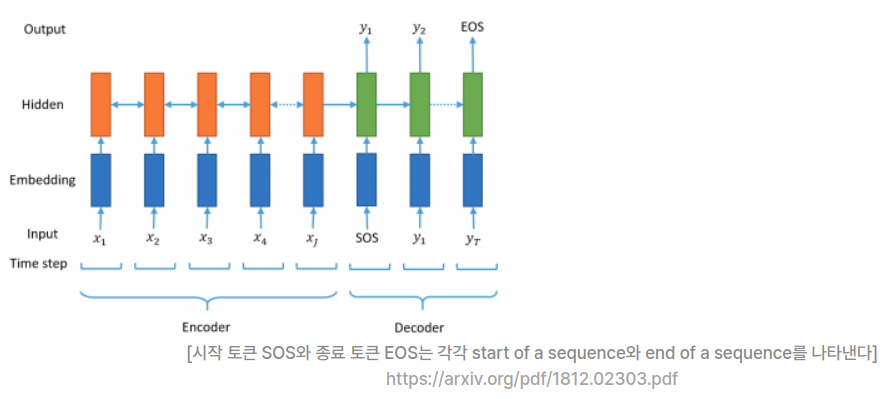



- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요. 

   ■ 시작토큰은 sostoken, 종료토큰은 eostoken이라 명명하고 앞, 뒤로 추가함. 

   ■ 디코더 - 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당,  
     종료 토큰이 맨 뒤에 붙는 문장의 이름 decoder_target 로 설정. 두 개의 문장 모두 headlines 열로부터 만들 거

In [23]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


- 아래 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [24]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('쓩')

쓩


#### 훈련 데이터와 테스트 데이터를 섞은후 분리.


- encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만듬.




In [25]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스로 데이터의 샘플 순서를 정의 => 샘플이 섞이게 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 섞인 데이터를 8:2 비율로 train, test 분리할 예정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14825


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 텍스트의 개수 :', len(encoder_input_train))
print('훈련 요약의 개수 :', len(decoder_input_train))
print('테스트 텍스트의 개수 :', len(encoder_input_test))
print('테스트 요약의 개수 :', len(decoder_input_test)) 

훈련 텍스트의 개수 : 59303
훈련 요약의 개수 : 59303
테스트 텍스트의 개수 : 14825
테스트 요약의 개수 : 14825


### 데이터 전처리하기 (3) 정수 인코딩


- 단어 집합(vocabulary) 만들기 및 정수 인코딩
  기계가 텍스트를 숫자로 처리하게 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔주려고 각 단어에 고유한 정수를 맵핑하는 작업이 필요.  
 
 
  ####   단어장(vocabulary) 만들기
  
- 훈련 데이터의 단어 집합을 만들기 : 우선 원문에 해당되는 Keras의 토크나이저를 사용해 encoder_input_train의 단어 집합 만듬.

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 : 단어장 만들기위한 준비
src_tokenizer.fit_on_texts(encoder_input_train) # train의 text 단어장 생성 
print('쓩') 

쓩


In [28]:
threshold = 7 # 등장 빈도수가 7회
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61685
등장 빈도가 6번 이하인 희귀 단어의 수: 42333
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19352
단어 집합에서 희귀 단어의 비율: 68.62770527680959
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.18473021818641


- encoder_input_train에는 6만여개의 단어. 



- 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 68%. 

  하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.18%. 
  
  
  
  
-  1줄 - 빈도 6회 이하인 19,306 단어 제외, 제외 단어를  19,000으로 제한.



  
 - 2줄 - 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한

In [29]:
src_vocab = 19000 # 단어장 크기 19,000
src_tokenizer = Tokenizer(num_words=src_vocab) #  텐서플러 doc에 num_words를  most common 빈도순
src_tokenizer.fit_on_texts(encoder_input_train) # 19,000개로 짤랐기때문에 train의 text 단어장 다시 만듬
print('쓩')

쓩


- text, headlines 정수 인코딩 = 텍스트 단어를 정수로 변환



- texts_to_sequences()는 단어장의 텍스트 단어를 정수로 변환하는 정수 인코딩을 수행.




- 현재 단어 집합의 크기를 19,000으로 제한해서 19,000이 넘는 숫자들은 정수 인코딩 후에는 사라짐.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3]) # ♣ encoder_input은  text에서 정수 시퀀스 된거, [:3] 슬라이스 0,1,2 3번째꺼, [] 3덩이 즉 정수 시퀀스 된 text 3덩이

[[28, 6, 1055, 359, 124, 45, 529, 6549, 1104, 2505, 1105, 117, 4152, 3336, 5, 6029, 166, 121, 1004, 4109, 84, 15915, 2437, 603, 338, 458, 28, 886, 517, 45, 846, 2046, 3336, 57], [607, 8, 81, 763, 17988, 3879, 76, 302, 2, 15070, 763, 607, 1538, 698, 25, 2123, 18, 119, 302, 10, 2097, 25, 1622, 5459, 4011, 246, 7678, 173, 192, 101, 2097, 5459, 1622, 829, 1446, 398, 111], [56, 1423, 6876, 52, 355, 167, 2814, 1371, 367, 1117, 450, 3186, 1423, 201, 32, 13183, 13184, 81, 6112, 23, 751, 116, 28, 2, 4231, 284, 436, 877, 11, 282, 1056, 399, 1763]]


#### headlines도 정수 시퀀스로 변환. 

- 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산 ->맨 첫 코드 from tensorflow.keras.preprocessing.text import Tokenizer 

In [31]:
tar_tokenizer = Tokenizer() # Tokenizer()를 tar_tokenizer라고 칭한다
tar_tokenizer.fit_on_texts(decoder_input_train)# 단어장 만듬 tar는 target
print('쓩')

쓩


- 아래 2줄 summery= tar 의 단어장 생성되고 각 단어에 고유한 정수가 부여되서 tar_tokenizer.word_index에 저장. 




- 6줄 tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장, 이를 통해 등장 빈도수가 6회 미만인 단어들이 몇 %인지등 확인.

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27316
등장 빈도가 5번 이하인 희귀 단어의 수: 18230
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9086
단어 집합에서 희귀 단어의 비율: 66.73744325669936
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.960239899098233


- target의 등장 빈도가 5회 이하가 약 67%. 하지만 훈련 데이터에서 등장 빈도로 차지하는 비중은 5.99% 뿐이고 모두 제거.





- 단어장 크기로 9,000로 제한

In [33]:
# headlines에서 사용빈도가 높은 단어만으로 단어 집합 생성 
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환 
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 27, 564, 2584, 690, 1744, 119, 2871, 2339, 128], [1, 577, 2872, 319, 1173, 244, 544, 5, 99, 8219], [1, 13, 219, 16, 2404, 715, 7, 209, 9, 2518, 639], [1, 128, 2724, 5747, 2222, 3, 199, 2873, 450], [1, 128, 90, 68, 5748, 104, 1929, 22, 126, 16, 22]]
target
decoder  [[27, 564, 2584, 690, 1744, 119, 2871, 2339, 128, 2], [577, 2872, 319, 1173, 244, 544, 5, 99, 8219, 2], [13, 219, 16, 2404, 715, 7, 209, 9, 2518, 639, 2], [128, 2724, 5747, 2222, 3, 199, 2873, 450, 2], [128, 90, 68, 5748, 104, 1929, 22, 126, 16, 22, 2]]


- target 정수 인코딩 작업완료. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 9,000이 넘는 숫자들은 존재X 



- 빈(empty) 샘플이 된 빈도수가 낮은 단어만으로 구성되었던 샘플들이 Text보다 headlines에 훨 많다.




- 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와보면. 여기서  요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 
  상태, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 
  그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나옴. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니. 





- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test라는 변수에 저장. 이 샘플들은 모두 삭제
 

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59303
훈련 레이블의 개수 : 59303
테스트 데이터의 개수 : 14825
테스트 레이블의 개수 : 14825


- 훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인.



#### 패딩하기

- text, headlines 시퀀스를 정수 시퀀스로 변환했다면, 서로 다른 길이의 샘플들을 병렬처리하기 위해 같은길이로 맞춰주는 패딩 작업을 해주어야함. 아까 정해둔 최대 길이로 패딩. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어.



#### 학습에 필요한 데이터 전처리 끝~ 

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('쓩')

쓩


###  모델 설계하기

#### 함수형 API를 이용해서 인코더를 설계

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 #  LSTM의 capacity == LSTM의 용량 크기(뉴런 개수)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128로, hidden state의 크기를 256으로 정의. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터. 




- 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아님.



- 인코더의 LSTM은 총 3개의 층으로 구성, 모델의 복잡도를 높임. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로.




- LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용가능. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 
  해결.



- 반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식. 즉 time step의 입력을 랜덤으로 생략. recurrent dropout은 일반적인   dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지.



- 아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것. 색이 있는 화살표는 dropout을 나타낸것. 
  (색이 다른 것은 다른 dropout mask를 사용했다는것) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용(오른쪽).  
  dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout.
  
  


https://arxiv.org/pdf/1603.05118v2.pdf recurrent dropout 논문

#### 디코더 설계

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와   cell state의 값을 넣줌.





- 디코더의 출력층을 설계

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야함. 
  그래서 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 softmax.
  
  


### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)


- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다. 




- 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보자.


  
  
  

- 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq. 
  그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법 - 어텐션 메커니즘 !
  
  
  

- 어텐션 메커니즘
  어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻. TensorFlow에 이미 구현된 어텐션 함수를 가져와서   디코더의 출력층에 어떤 방식으로 결합하는지 파악. 어텐션 함수중 하나 Bahdanau 스타일의 어텐션. 
  
  
  


- 아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

###  모델 훈련



- 설계한 모델을 가지고 train을 진행.



- 좀더 충분한 train 을 시키기위해 EarlyStopping의  patience를 노드의 2 에서 5로 진행.

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 25s 86ms/step - loss: 2.5893 - val_loss: 4.3169
Epoch 2/50
232/232 [==============================] - 19s 82ms/step - loss: 2.5208 - val_loss: 4.3263
Epoch 3/50
232/232 [==============================] - 19s 83ms/step - loss: 2.4775 - val_loss: 4.3280
Epoch 4/50
232/232 [==============================] - 19s 84ms/step - loss: 2.4440 - val_loss: 4.3342
Epoch 00004: early stopping


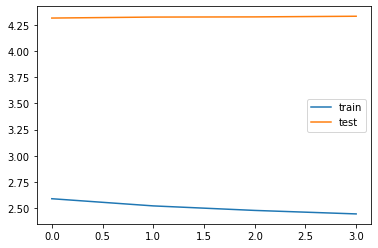

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


###  인퍼런스 모델 구현하기 = 추론단계




- 테스트 단계에서는 정수 인덱스 행렬상태인 데이터를 텍스트로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 준비

In [64]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('쓩')

쓩


-  seq2seq는 훈련 때와 실제 동작 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행.





- 훈련에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은   
  통모델 하나만 준비.
  그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복구조로 동작해야 하기 때문에 인퍼런스를 위한 모델설계를 별도로.   이때는 인코더 모델과 디코더 모델을 분리해서 설계.

In [65]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('쓩')

쓩


- 어텐션 메커니즘을 사용하는 출력층

In [66]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('쓩')

쓩


- 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만듬

In [67]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('쓩')

쓩


### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)


- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교.



- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과확인. 정수 시퀀스를 텍스트 시퀀스로 변환함수를 만듬. 




- 함수를 만들 때, Text의 정수시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 headlines의 정수시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 
  종료 토큰의 인덱스를 출력에서 제외

In [68]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('쓩')

쓩


- 테스트 데이터 약 5개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [69]:
for i in range(5):
    print("* 원문 :", seq2text(encoder_input_test[i]))
    print("* 실제 요약 :", seq2summary(decoder_input_test[i]))
    print("* 추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

* 원문 : winners nobel prizes named october beginning medicine laureates followed physics chemistry peace economics coming days however literature nobel prize postponed first time years due metoo scandal husband swedish academy member accused rape 
* 실제 요약 : nobel prize announcements from oct no literature award in 
* 추상적 요약 :  nobel winner wins nobel prize in the


* 원문 : trinamool congress announced plans organise brahmin west bengal district january around brahmins invited conduct puja event slamming tmc chief mamata banerjee bjp leader rahul sinha said party scared losing votes hindu majority focussed minority appeasement 
* 실제 요약 : trinamool congress to organise brahmin in wb 
* 추상적 요약 :  bjp leader ahead of parliament ahead of republic day


* 원문 : maldives president abdulla yameen abdul gayoom thursday lifted state emergency imposed country period days emergency imposed maldives supreme court ordered release nine jailed opposition mps including country first democratically elected

#### 실제 요약과 추상적 요약 결과 비교


- 두요약을 비교해봤을 때 가끔 단어거 겹치는 경우가 일부 있을 정도이고 서로 동떨어진 내용의 요약이  대부분이다.
  
  

- seq2seq와 어텐션의 자체의 조합을 바꿈,  beam search, 인코더 - 디코더 자체의 구조를 변경는 Transformer

  등의 다양한 시도를 했으면 요약을 더 잘할수도 있었겠음.

### Step 5. Summa을 이용해서 추출적 요약해보기


- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 즉 추출적 요약은  

  기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 오히려 낮음.
  
  
  
  

- Summa의 summarize를 사용하여 추출적 요약을 해보자.




- Summa의 summarize()의 인자로 사용되는 값들.

-  text (str) : 요약할 테스트.

-  ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값

-  words (int or None, optional) – 출력에 포함할 단어 수.

-  만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시.

   split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
   
   

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행. 

  그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 
  
  비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여본다. 원문의 0.005%만을 출력하도록 설정.

In [70]:
import requests
from summa.summarizer import summarize

- idx(index)
  "if idx == 20:"은 특정 텍스트에서 20번째 문자 또는 단어를 찾아서 해당 단어를 출력. 

In [71]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 20:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, ratio=0.8))
    print("\n")

원문 : new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
실제 요약 : new zealand end rohit sharma led india match winning streak
예측 요약 : 


원문 : aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years
실제 요약 : aegon life iterm insurance plan helps customers save tax
예측 요약 : 


원문 : pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre
실제 요약 : rahat fateh ali khan denies getting notice for smugglin

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해서 '추출적 요약'에는 원문을 시도해보았다.



-  전처리를 하질않아 구두점등이 있으나 '문법적 완성도' 나 '핵심'단어포함'측면은 나쁘지않으나 실제요약'보다 내용이 더 길어 아쉽다.


- 위 추출적 요약 코드를 실행할때 '예측요약' idx == 10 . 원문출력비율 ratio=0.0005 로 설정할때보다  idx == 20, ratio=0.55로 을 늘렸을 때 

  '예측요약'의 빈곳이 많이 줄어들었었으나 다시 새로운 시도를 하느라 Run all above 하니 '예측 요약'이 나오질 않아 마감시간이 촉박해서 이전에 추출된 문장으로 마무리.

|요약 형태|요약내용 비교|문법적 완성도|핵심단어 포함정도|
|:---: |:---:|:---:|:---:|
|추론적 요약|nobel winner wins nobel prize in the                 |문법적 완성도 썩 좋지않음|핵심단어는 들어감 |
|추출적 요약|taliban ghani afghanistan comments came amid talks us|문법적으로 오류 많음     |핵심단어 일부 빠짐|



- 추론적 요약이 성능이 문법적 완성도에서 더 좋고 핵심단어가 더 많이 포함되어 있음.

### Reference

- https://tykimos.github.io/2019/12/25/Python_Lambda/  lamda 



- https://arxiv.org/pdf/1603.05118v2.pdf recurrent dropout 



- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping Early Stopping



- https://wikidocs.net/73161 바다나우 attention




- https://blog.naver.com/econophysics/222661264595 attention




### 결론 및 회고 


- 본문을 요약하는게 summary가 아니고  headline으로  바뀌어 임의의 변수 summary도 혼재되있어 코드 분간하는데 좀 헷갈렸음.



- 좀더 충분한 train 을 시키기위해 EarlyStopping의  patience를 노드의 5 에서 2로 진행했더니 validation loss 4.52 에서 약간 낮아져서 .

  patience = 2로  validation loss 4.3 다시 낮춤. 하면할수록 더 높아지는 상황이라 patience의 속성을 파악할수 있었음.
 
 
- 위 추출적 요약 코드를 실행할때 '예측요약' idx == 10 . 원문출력비율 ratio=0.0005 로 설정할때보다  idx == 20, ratio=0.55로 을 늘렸을 때 

  '예측요약'의 빈곳이 많이 줄어들었다  
  


- Attention 메커니즘, 성능을 개선하기위한 seq2seq와 어텐션의 자체의 조합을 바꿈,  beam search, 인코더 - 디코더 자체의 구조를 변경등 Transformer
  등의 다양한 시도를 충분히 하지 못했다. 추후에 시간이 되면 시행착오를 통해 요약봇을 성능을 올려보고싶다. 
  
  